Processed data saved to '../data/processed_data.csv'.


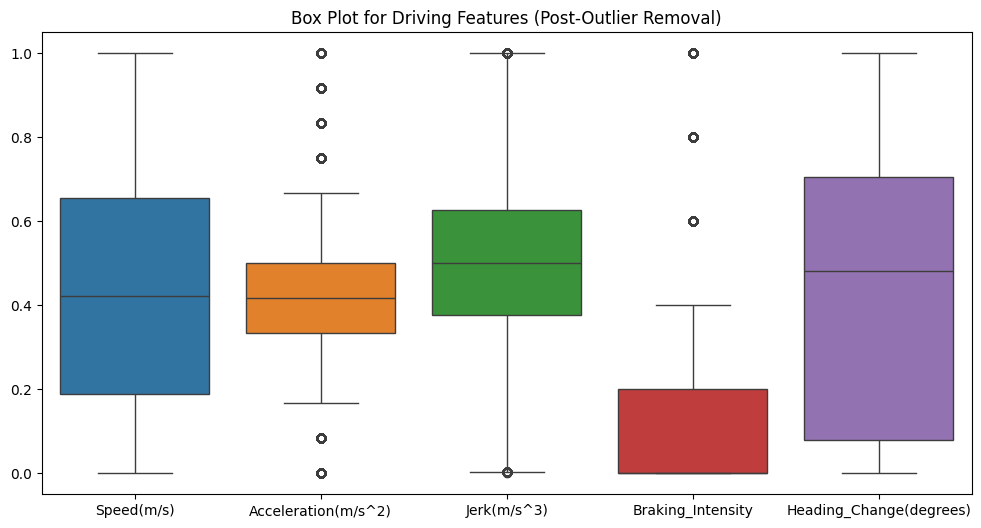

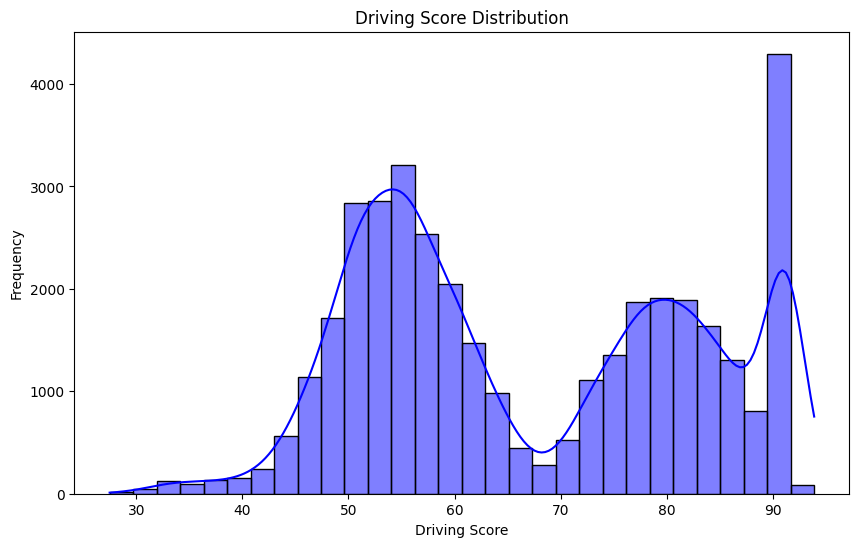

In [18]:
import os
import pandas as pd
import numpy as np
from math import radians, sin, cos, sqrt, atan2, degrees
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure the 'data' directory exists
output_directory = 'data'
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Load the driving data
df = pd.read_csv('../data/driving_data.csv')

# Ensure that Time_Step, Latitude, and Longitude are numeric
df['Time_Step'] = pd.to_numeric(df['Time_Step'], errors='coerce')
df['Latitude'] = pd.to_numeric(df['Latitude'], errors='coerce')
df['Longitude'] = pd.to_numeric(df['Longitude'], errors='coerce')

# Drop rows with missing values in important columns
df = df.dropna(subset=['Time_Step', 'Latitude', 'Longitude'])

# Convert Speed from km/h to m/s
df['Speed(m/s)'] = df['Speed(km/h)'] * 0.27778

# Haversine formula to calculate distance between two GPS points
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of Earth in kilometers
    d_lat = radians(lat2 - lat1)
    d_lon = radians(lon2 - lon1)
    lat1 = radians(lat1)
    lat2 = radians(lat2)

    a = sin(d_lat / 2)**2 + cos(lat1) * cos(lat2) * sin(d_lon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    return R * c * 1000  # Distance in meters

# Calculate differences for time, latitude, and longitude
df['Time_Diff'] = df['Time_Step'].diff().fillna(0)

# Shift latitude and longitude for distance calculation
df['Lat_Shifted'] = df['Latitude'].shift(1)
df['Lon_Shifted'] = df['Longitude'].shift(1)

# Calculate distance between consecutive points
df['Distance(m)'] = df.apply(lambda row: haversine(row['Lat_Shifted'], row['Lon_Shifted'], row['Latitude'], row['Longitude']), axis=1)

# Calculate acceleration (m/s²) and filter out extreme values (beyond ±10 m/s²)
df['Acceleration(m/s^2)'] = df['Speed(m/s)'].diff() / df['Time_Diff'].replace(0, np.nan).fillna(1)

# Calculate jerk (m/s³)
df['Jerk(m/s^3)'] = df['Acceleration(m/s^2)'].diff() / df['Time_Diff'].replace(0, np.nan).fillna(1)

# Calculate braking intensity (absolute value of negative acceleration)
df['Braking_Intensity'] = df['Acceleration(m/s^2)'].apply(lambda x: abs(x) if x < 0 else 0)

# Function to calculate heading change
def calculate_heading_change(lat1, lon1, lat2, lon2):
    d_lon = lon2 - lon1
    y = sin(radians(d_lon)) * cos(radians(lat2))
    x = cos(radians(lat1)) * sin(radians(lat2)) - sin(radians(lat1)) * cos(radians(lat2)) * cos(radians(d_lon))
    heading = atan2(y, x)
    return abs(degrees(heading))  # Return absolute heading change in degrees

# Calculate heading change
df['Heading_Change(degrees)'] = df.apply(lambda row: calculate_heading_change(row['Lat_Shifted'], row['Lon_Shifted'], row['Latitude'], row['Longitude']), axis=1)

# Remove outliers using Z-score method
z_scores = np.abs(stats.zscore(df[['Speed(m/s)', 'Acceleration(m/s^2)', 'Jerk(m/s^3)', 'Braking_Intensity', 'Heading_Change(degrees)']].fillna(0)))
df = df[(z_scores < 3).all(axis=1)]  # Keep data within 3 standard deviations

# Load sensitive locations (school, hospital, etc.)
sensitive_locations = pd.read_csv('../data/sensitive_location.csv')

# Function to calculate SASV (Sensitive Area Speed Violation)
def haversine_vectorized(lat1, lon1, lat2_series, lon2_series):
    R = 6371  # Earth's radius in kilometers
    d_lat = np.radians(lat2_series - lat1)
    d_lon = np.radians(lon2_series - lon1)
    lat1 = np.radians(lat1)
    lat2_series = np.radians(lat2_series)
    a = np.sin(d_lat / 2)**2 + np.cos(lat1) * np.cos(lat2_series) * np.sin(d_lon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c * 1000  # Distance in meters

def calculate_sasv(lat, lon, speed, sensitive_locations):
    sensitive_distances = haversine_vectorized(lat, lon, sensitive_locations['Latitude'], sensitive_locations['Longitude'])
    if np.any(sensitive_distances < 300):  # Within 300 meters of sensitive areas
        if speed > 8.33:  # Speed > 30 km/h in sensitive area
            return 1
    return 0

# Apply SASV calculation
df['SASV'] = df.apply(lambda row: calculate_sasv(row['Latitude'], row['Longitude'], row['Speed(m/s)'], sensitive_locations), axis=1)

# Calculate rule violation score for exceeding general speed limit
def calculate_speed_violation(row):
    speed_limit = 13.89  # ~50 km/h general speed limit
    if row['Speed(m/s)'] > speed_limit:
        return 1  # Speed violation
    return 0

df['Speed_Violation'] = df.apply(calculate_speed_violation, axis=1)

# ---------- Driving Score Calculation ---------- #
df['Driving_Score'] = 100

# Normalize the key features using MinMaxScaler
scaler = MinMaxScaler()
df[['Speed(m/s)', 'Acceleration(m/s^2)', 'Jerk(m/s^3)', 'Braking_Intensity', 'Heading_Change(degrees)']] = scaler.fit_transform(
    df[['Speed(m/s)', 'Acceleration(m/s^2)', 'Jerk(m/s^3)', 'Braking_Intensity', 'Heading_Change(degrees)']])

# Apply penalties based on normalized features
df['Driving_Score'] -= df['Speed(m/s)'] * 25  # Speed penalty
df['Driving_Score'] -= df['Acceleration(m/s^2)'] * 15  # Acceleration penalty
df['Driving_Score'] -= df['Jerk(m/s^3)'] * 5  # Jerk penalty
df['Driving_Score'] -= df['Braking_Intensity'] * 5  # Braking intensity penalty
df['Driving_Score'] -= df['Heading_Change(degrees)'] * 10  # Heading change penalty

# Penalty for violations
df['Driving_Score'] -= df['SASV'] * 15  # Penalty for violating sensitive areas
df['Driving_Score'] -= df['Speed_Violation'] * 15  # Penalty for general speed violation

# Ensure the score is within the range [0, 100]
df['Driving_Score'] = df['Driving_Score'].clip(upper=100, lower=0)

# Driving Category based on score
def categorize_driving_score(score):
    if score > 80:
        return 'Safe'
    elif score > 60:
        return 'Moderate'
    else:
        return 'Risky'

df['Driving_Category'] = df['Driving_Score'].apply(categorize_driving_score)

# Save the processed data
processed_columns = ['TripId', 'Time_Step', 'Latitude', 'Longitude', 'Speed(m/s)', 'Acceleration(m/s^2)', 
                     'Jerk(m/s^3)', 'Braking_Intensity', 'Heading_Change(degrees)', 'SASV', 'Speed_Violation', 'Driving_Score', 'Driving_Category']
processed_data = df[processed_columns]
processed_data.to_csv('../data/processed_data.csv', index=False)

print("Processed data saved to '../data/processed_data.csv'.")

# ---------- Visualizations ---------- #

# Box Plot for features
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[['Speed(m/s)', 'Acceleration(m/s^2)', 'Jerk(m/s^3)', 'Braking_Intensity', 'Heading_Change(degrees)']])
plt.title("Box Plot for Driving Features (Post-Outlier Removal)")
plt.show()

# Driving Score Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['Driving_Score'], bins=30, kde=True, color='blue')
plt.title("Driving Score Distribution")
plt.xlabel("Driving Score")
plt.ylabel("Frequency")
plt.show()


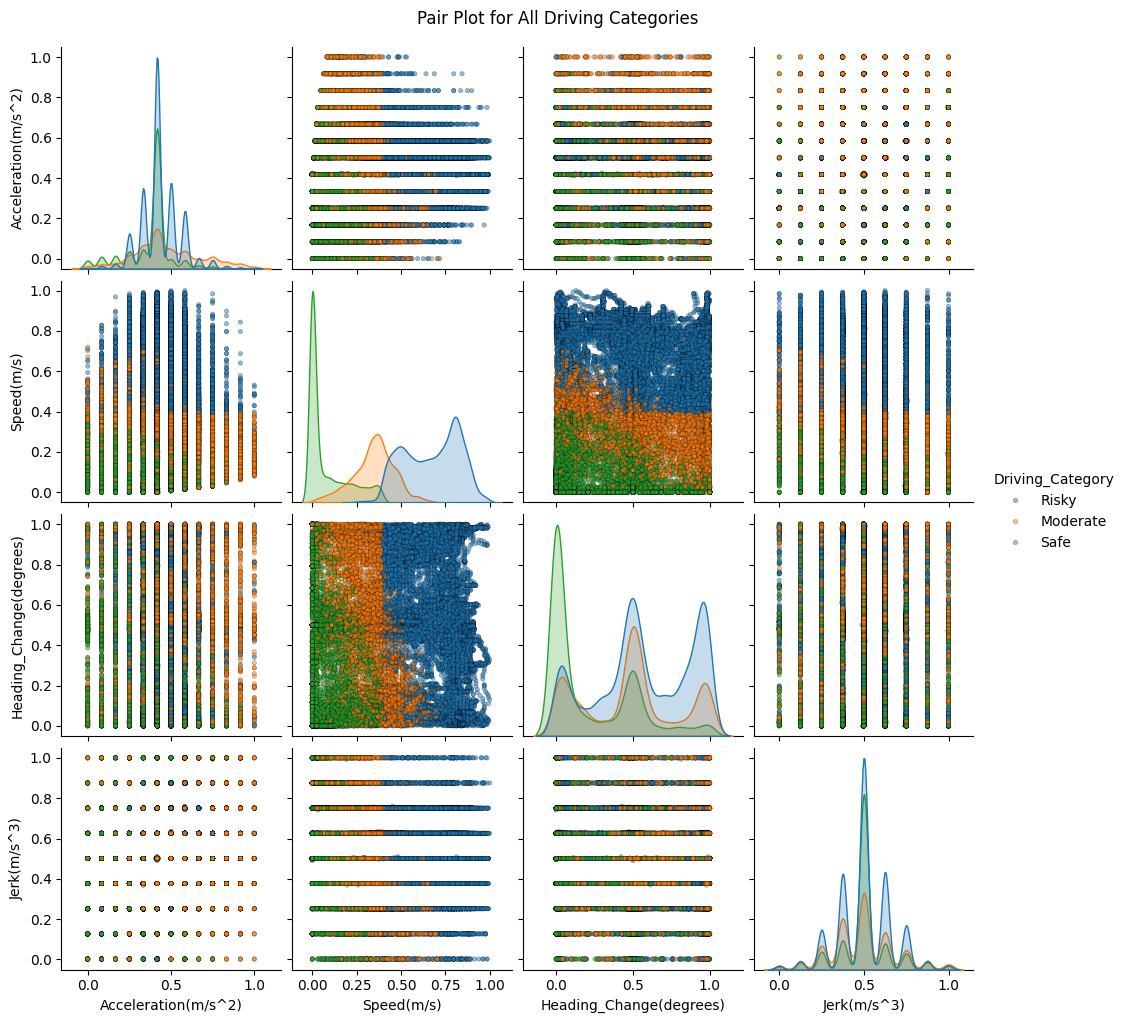

In [19]:

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Load the processed data
df = pd.read_csv('../data/processed_data.csv')  # Ensure the correct path to your processed data

# Select features for the pair plot along with the Driving Category
selected_features = ['Acceleration(m/s^2)', 'Speed(m/s)', 'Heading_Change(degrees)', 'Jerk(m/s^3)', 'Driving_Category']

# Create a pair plot for all driving categories
sns.pairplot(df[selected_features], hue='Driving_Category', plot_kws={'alpha': 0.5, 's': 10, 'edgecolor': 'k'})

# Display the plot
plt.suptitle('Pair Plot for All Driving Categories', y=1.02)
plt.show()
